In [1]:
import numpy as np
import phate
from heatgeo.embedding import HeatGeo
import scprep
from scipy.spatial.distance import pdist, squareform
import demap


In [2]:
# data = np.load("/gpfs/gibbs/pi/krishnaswamy_smita/dl2282/dmae/data/swiss_roll_1.0_seed1.npz")
datas = [np.load(f"/gpfs/gibbs/pi/krishnaswamy_smita/dl2282/dmae/data/swiss_roll_noise0.1_seed{i}.npz") for i in range(1,4)]
# datas = [np.load(f"/gpfs/gibbs/pi/krishnaswamy_smita/dl2282/dmae/data/swiss_roll_noise1.0_seed{i}.npz") for i in range(1,4)]
# data = np.load("/gpfs/gibbs/pi/krishnaswamy_smita/dl2282/dmae/data/s_curve_noise0.1.npz")
# data = np.load("/gpfs/gibbs/pi/krishnaswamy_smita/dl2282/dmae/data/swiss_roll_noise0.1_seed1.npz")

In [3]:
# datas

In [4]:
x0 = datas[0]['data']
x1 = datas[1]['data']
x2 = datas[2]['data']
x1[:,1] = x1[:,1] + x0[:,1].max()
x = np.r_[x0,x1]
x2[:,1] = x2[:,1] + x[:,1].max()
x = np.r_[x,x2]

In [5]:
colors = np.r_[*[data['colors'] for data in datas]]

In [6]:
x0 = datas[0]['data_gt']
x1 = datas[1]['data_gt']
x2 = datas[2]['data_gt']
x1[:,1] = x1[:,1] + x0[:,1].max()
x_gt = np.r_[x0,x1]
x2[:,1] = x2[:,1] + x_gt[:,1].max()
x_gt = np.r_[x_gt,x2]

In [7]:
np.random.seed(42)
subset_idx = np.random.choice(len(x), size=3000, replace=False)
is_train = np.array([i in (subset_idx) for i in range(len(x))])

In [8]:
is_train.sum()

3000

In [9]:
# x = data['data']
# x_gt = data['data_gt']
# colors = data['colors']
# x[:,1] = x[:,1] * 3
# x_gt[:,1] = x_gt[:,1] * 3

/gpfs/gibbs/pi/krishnaswamy_smita/xingzhi/.conda_envs/geosink/lib/python3.11/site-packages/scprep/plot/utils.py:99: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  fig.tight_layout()
/gpfs/gibbs/pi/krishnaswamy_smita/xingzhi/.conda_envs/geosink/lib/python3.11/site-packages/scprep/plot/utils.py:104: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


<Axes3D: >

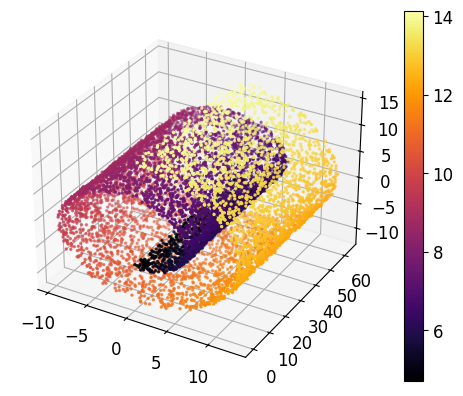

In [10]:
scprep.plot.scatter3d(x, c=colors)

In [11]:
phate_op = phate.PHATE(knn=30, t=100, random_state=3)
# phate_op = phate.PHATE()
x_phate = phate_op.fit_transform(x)

Calculating PHATE...
  Running PHATE on 9000 observations and 3 variables.
  Calculating graph and diffusion operator...
    Calculating KNN search...
    Calculated KNN search in 0.64 seconds.
    Calculating affinities...
    Calculated affinities in 0.27 seconds.
  Calculated graph and diffusion operator in 0.94 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 1.28 seconds.
    Calculating KMeans...
    Calculated KMeans in 14.29 seconds.
  Calculated landmark operator in 17.03 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 3.64 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 7.50 seconds.
Calculated PHATE in 29.13 seconds.


/gpfs/gibbs/pi/krishnaswamy_smita/xingzhi/.conda_envs/geosink/lib/python3.11/site-packages/scprep/plot/utils.py:104: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


<Axes: title={'center': 'PHATE knn=30, t=100'}>

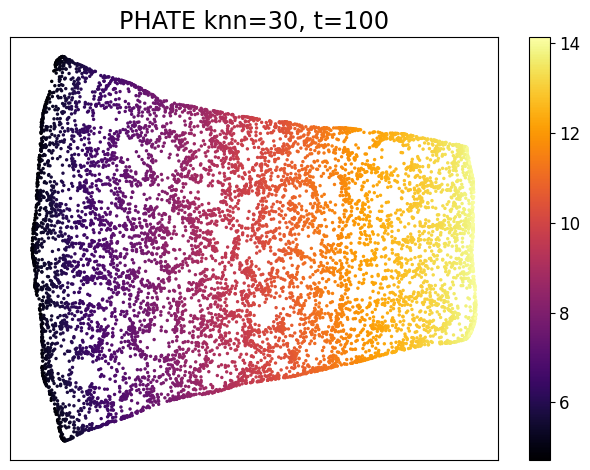

In [12]:
scprep.plot.scatter2d(x_phate, c=colors, ticks=False, title=f"PHATE knn=30, t=100")

In [13]:
x_gt.shape

(9000, 3)

In [14]:
# data_dict = {file: data[file] for file in data.files}
data_dict = dict(
    data=x,
    data_gt=x_gt,
    colors=colors,
    is_train=is_train,
)

In [15]:
data_dict['phate'] = x_phate
# diff_potential = phate_op.diff_potential[is_train]
diff_potential = phate_op.diff_potential
# dist_mat = np.zeros((x.shape[0], x.shape[0]))
phate_dist = squareform(pdist(diff_potential))
# dist_mat[is_train][:,is_train] = phate_dist # only storing the training ones to save time.
# data_dict['dist'] = dist_mat
data_dict['dist'] = phate_dist
np.savez("../data/swissroll0.1_phate_flat.npz", **data_dict)

/gpfs/gibbs/pi/krishnaswamy_smita/xingzhi/.conda_envs/geosink/lib/python3.11/site-packages/scprep/plot/utils.py:104: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


<Axes: title={'center': 'Swiss Roll PHATE knn=30, t=100, DEMaP=0.685'}>

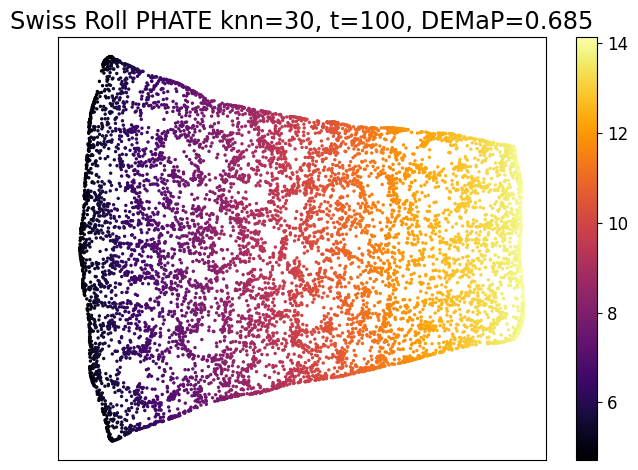

In [16]:
val = demap.DEMaP(x_gt[is_train], x_phate[is_train], knn=30)
val = np.round(val, 3)
scprep.plot.scatter2d(x_phate, c=colors, ticks=False, title=f"Swiss Roll PHATE knn=30, t=100, DEMaP={val}")

In [17]:
x_gt.shape

(9000, 3)

In [18]:
import pickle
with open('../data/swissroll0.1_phate_flat_phate_op.pkl', 'wb') as file:
    pickle.dump(phate_op, file)

Hi Danqi! I was wondering if you could benchmark the affinity matching on these datasets? I concatenated a few of your datasets, so they are longer in the y axis while retaining the same density, and have a good embedding after increasing t as Smita wanted. The parameters I used was phate_op = phate.PHATE(knn=30, t=100, random_state=3), and I also saved the phate operators in case it comes in handy. 
/gpfs/gibbs/pi/krishnaswamy_smita/xingzhi/dmae/data/swissroll0.1_phate_flat.npz
/gpfs/gibbs/pi/krishnaswamy_smita/xingzhi/dmae/data/swissroll0.1_phate_flat_phate_op.pkl
/gpfs/gibbs/pi/krishnaswamy_smita/xingzhi/dmae/data/scurve0.1_phate_flat.npz
/gpfs/gibbs/pi/krishnaswamy_smita/xingzhi/dmae/data/scurve0.1_phate_flat_phate_op.pkl

In [1]:
import numpy as np

In [7]:
# data = np.load("../data/swissroll0.1_phate_flat.npz")
data = np.load("../data/scurve0.1_phate_flat.npz")

In [8]:
data['dist'][~data['is_train']][:,~data['is_train']]

array([[  0.        , 237.05425382, 214.44518454, ..., 208.60683334,
        116.58361369, 127.2560966 ],
       [237.05425382,   0.        ,  62.80061638, ..., 112.65196424,
        216.21346642, 231.33001998],
       [214.44518454,  62.80061638,   0.        , ...,  56.5508904 ,
        169.33810951, 188.38144643],
       ...,
       [208.60683334, 112.65196424,  56.5508904 , ...,   0.        ,
        135.98244591, 150.18437115],
       [116.58361369, 216.21346642, 169.33810951, ..., 135.98244591,
          0.        ,  42.40415455],
       [127.2560966 , 231.33001998, 188.38144643, ..., 150.18437115,
         42.40415455,   0.        ]])